float32 (196, 3, 256, 256) 0.0 9.999571 0.7867459


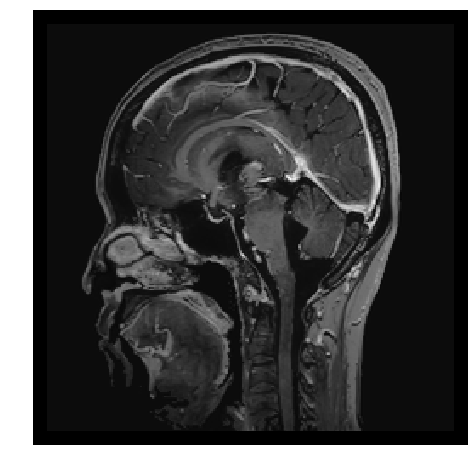

In [9]:
%reload_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (10, 8)

from subtle.dnn.generators import GeneratorUNet2D
import subtle.utils.io as suio
from subtle.data_loaders.slice_loader import SliceLoader
import subtle.subtle_loss as suloss
from subtle.dnn.helpers import clear_keras_memory, set_keras_memory
from keras.optimizers import Adam

from keract import get_activations, display_activations, display_heatmaps
from keras.utils.vis_utils import plot_model

def show_img(img, title='', axis=False, vmin=None, vmax=None, cmap='gray'):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args, cmap=cmap)
    plt.title(title, fontsize=15)

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.set_cmap('gray')

npy_file = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_256/NO57.npy'

study_data = np.load(npy_file)[0]

print(study_data.dtype, study_data.shape, study_data.min(), study_data.max(), study_data.mean())
show_img(study_data[98, 2, :, :])

In [3]:
clear_keras_memory()
set_keras_memory(1.0)

loss_function = suloss.mixed_loss(l1_lambda=1.0, ssim_lambda=0.0)
metrics_monitor = [suloss.l1_loss]

model = GeneratorUNet2D(
            num_channel_input=14, num_channel_output=1,
            img_rows=240, img_cols=240,
            loss_function=loss_function,
            metrics_monitor=metrics_monitor,
            lr_init=0.001,
            verbose=2,
            checkpoint_file='/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_vgg.checkpoint')
model.load_weights()



Building unet2d model...
Tensor("model_input:0", shape=(?, 240, 240, 14), dtype=float32)

Tensor("relu_conv_enc_1_2/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("maxpool_1/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("relu_conv_enc_2_2/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("maxpool_2/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("relu_conv_enc_3_2/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("maxpool_3/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("relu_conv_center/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_center/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("relu_conv_dec_2_2/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("cat_1/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("relu_conv_dec_3_2/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("cat_2/concat:0", shape=(?, 120, 120, 192), dtype=float32)
Tensor("relu_conv_dec

In [4]:
prediction_generator = SliceLoader(
    data_list=['/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO57.h5'],
    file_ext='h5',
    batch_size=1,
    shuffle=False,
    verbose=0,
    residual_mode=False,
    slices_per_input=7,
    resize=240,
    slice_axis=[0, 2, 3],
    brain_only=False
)

gen info float32 (240, 240) 0.0 8.342339 0.8529289


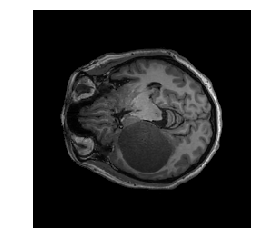

In [5]:
gen_item = prediction_generator.__getitem__(300)[0]
gen_slice = gen_item[0, :, :, 2]
print('gen info', gen_slice.dtype, gen_slice.shape, gen_slice.min(), gen_slice.max(), gen_slice.mean())
show_img(gen_slice)

In [6]:
y_pred = model.model.predict_generator(
    generator=prediction_generator,
    max_queue_size=16,
    workers=1,
    use_multiprocessing=False,
    verbose=0
)
print(y_pred.shape)


(676, 240, 240, 1)


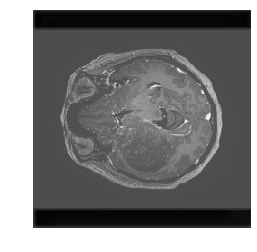

In [7]:
show_img(y_pred[298, :, :, 0])

['model_input', 'conv_enc_1_0', 'relu_conv_enc_1_0', 'conv_enc_1_1', 'relu_conv_enc_1_1', 'conv_enc_1_2', 'relu_conv_enc_1_2', 'maxpool_1', 'conv_enc_2_0', 'relu_conv_enc_2_0', 'conv_enc_2_1', 'relu_conv_enc_2_1', 'conv_enc_2_2', 'relu_conv_enc_2_2', 'maxpool_2', 'conv_enc_3_0', 'relu_conv_enc_3_0', 'conv_enc_3_1', 'relu_conv_enc_3_1', 'conv_enc_3_2', 'relu_conv_enc_3_2', 'maxpool_3', 'conv_center', 'relu_conv_center', 'add_center', 'upsample_2', 'cat_1', 'conv_dec_2_0', 'relu_conv_dec_2_0', 'conv_dec_2_1', 'relu_conv_dec_2_1', 'conv_dec_2_2', 'relu_conv_dec_2_2', 'upsample_3', 'cat_2', 'conv_dec_3_0', 'relu_conv_dec_3_0', 'conv_dec_3_1', 'relu_conv_dec_3_1', 'conv_dec_3_2', 'relu_conv_dec_3_2', 'upsample_4', 'cat_3', 'conv_dec_4_0', 'relu_conv_dec_4_0', 'conv_dec_4_1', 'relu_conv_dec_4_1', 'conv_dec_4_2', 'relu_conv_dec_4_2', 'model_output', 'linear_model_output']


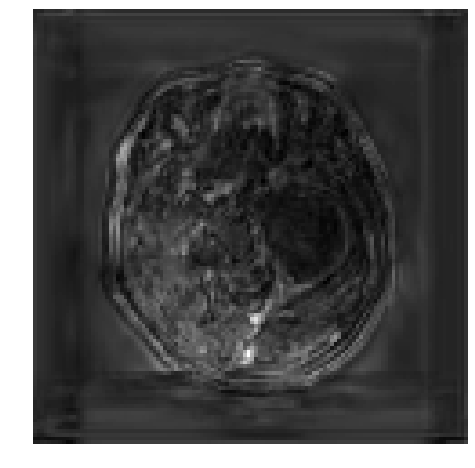

In [15]:
# study_data = suio.load_h5_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO57.h5')

# net_ip = np.transpose(np.concatenate([study_data[90:97, 0], study_data[90:97, 1]]), (1, 2, 0))
# net_ip = np.array([net_ip])

layer_names = [l.name for l in model.model.layers]
print(layer_names)

net_ip = prediction_generator.__getitem__(300)[0]
net_ip = np.rot90(net_ip, k=3, axes=(1, 2))
net_ip = np.flip(net_ip, axis=2)
show_img(net_ip[0, ..., 0])
lname = 'relu_conv_dec_3_1'

activations = get_activations(model.model, net_ip, layer_name=lname)[lname]

activ_pool = np.sum(activations, axis=3)
np.save('/home/srivathsa/projects/act_pool_2.npy', activ_pool)
show_img(activ_pool[0])

# activations = sorted(activations.items(), key=lambda act: layer_names.index(act[0].split(':')[0].split('/')[0]))

# for act in activations:
#     print(act[0], act[1].shape)

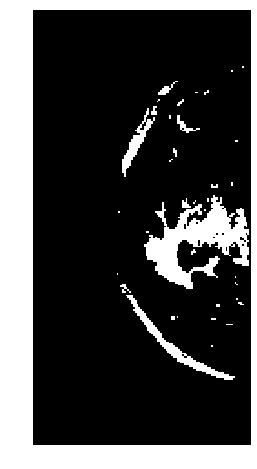

In [51]:
ip_sl = net_ip[0, ..., 0]

lhs = ip_sl[:, :120]
rhs = np.flip(ip_sl[:, 120:], axis=1)
diff = lhs - rhs
show_img(diff > 2)

0.0 0.9901531
0.0 0.99713165


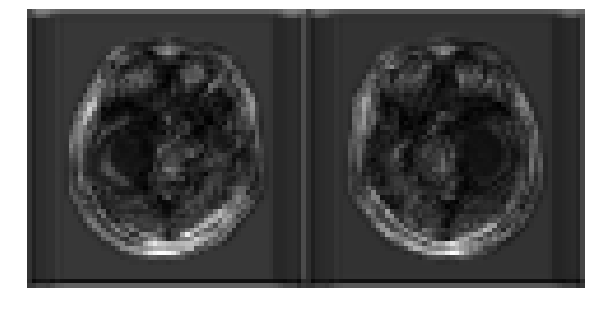

In [21]:
act1 = np.load('/home/srivathsa/projects/act_pool_1.npy')
act2 = np.load('/home/srivathsa/projects/act_pool_2.npy')
act1 = (act1 - act1.min()) / act1.max()
act2 = (act2 - act2.min()) / act2.max()
print(act1.min(), act1.max())
print(act2.min(), act2.max())

show_img(np.hstack([act1[0], act2[0]]))

In [ ]:
act_subset = []
keywords = ['max_pooling', 'up_sampling', 'add_1']
for layer_name, activation in activations:
    kw_exists = np.sum([1 if kw in layer_name else 0 for kw in keywords]) > 0
    if kw_exists:
        print(layer_name, activation.shape)
        act_subset.append({layer_name: activation})

In [ ]:
act_idx = 0
key = list(act_subset[act_idx].keys())[0]
activ_0 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 31, 1)):
    show_img(activ_0[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 1
key = list(act_subset[act_idx].keys())[0]
activ_1 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 63, 1)):
    show_img(activ_1[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 2
key = list(act_subset[act_idx].keys())[0]
activ_2 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 127, 1)):
    show_img(activ_2[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 3
key = list(act_subset[act_idx].keys())[0]
activ_3 = act_subset[act_idx][key][0]


pool = np.sum(activ_3, axis=2)

t1 = pool.max() * 0.15
t2 = pool.max() * 0.75
th_img = np.logical_and((pool > t1), (pool < t2))


show_img(pool)

# @interact
# def show_act(idx=(0, 127, 1)):
#     show_img(activ_3[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 4
key = list(act_subset[act_idx].keys())[0]
activ_4 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 127, 1)):
    show_img(activ_4[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 5
key = list(act_subset[act_idx].keys())[0]
activ_5 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 63, 1)):
    show_img(activ_5[:, :, idx], title=key, cmap='afmhot')

In [ ]:
act_idx = 6
key = list(act_subset[act_idx].keys())[0]
activ_6 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 31, 1)):
    show_img(activ_6[:, :, idx], title=key, cmap='afmhot')

In [ ]:
display_heatmaps(act_subset[1], study_data[168, 2])

In [ ]:
display_heatmaps(act_subset[6], study_data[168, 2])